# Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import optuna
import scipy.stats as stats
from optuna.visualization import plot_optimization_history, plot_param_importances
import plotly.io as pio

# Evade the future warning regarding xgboost GPU support
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/Users/tamasbarczikay/VScode_projects/python-xgboost-supervised/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [3]:
file_path = '/Users/tamasbarczikay/VScode_projects/python-xgboost-supervised/miami-housing.csv'
data = pd.read_csv(file_path)
data = data[['PARCELNO', 'SALE_PRC', 'age', 'structure_quality', 'CNTR_DIST', 'LND_SQFOOT', 'TOT_LVG_AREA']]

# Drop duplicates based on PARCELNO, keep the first occurrence
data = data.drop_duplicates(subset='PARCELNO', keep='first')

# Number of observations and data types
print(f'We have {data.shape[0]} observations after dropping duplicates.')

print("\nData Types:")
print(data.dtypes)

# Get baseline summary statistics
print("\nBaseline Summary Statistics:")
print(data.describe().round(1))

We have 13776 observations after dropping duplicates.

Data Types:
PARCELNO               int64
SALE_PRC             float64
age                    int64
structure_quality      int64
CNTR_DIST            float64
LND_SQFOOT             int64
TOT_LVG_AREA           int64
dtype: object

Baseline Summary Statistics:
           PARCELNO   SALE_PRC      age  structure_quality  CNTR_DIST  \
count  1.377600e+04    13776.0  13776.0            13776.0    13776.0   
mean   2.357748e+12   400746.4     30.6                3.5    68625.8   
std    1.198670e+12   317868.5     21.1                1.1    31990.8   
min    1.020008e+11    72000.0      0.0                1.0     3825.6   
25%    1.079160e+12   235000.0     14.0                2.0    42955.2   
50%    3.040305e+12   311100.0     26.0                4.0    66039.8   
75%    3.060180e+12   430000.0     46.0                4.0    89542.6   
max    3.660170e+12  2650000.0     96.0                5.0   159976.5   

       LND_SQFOOT  TOT_LVG_A

# EDA

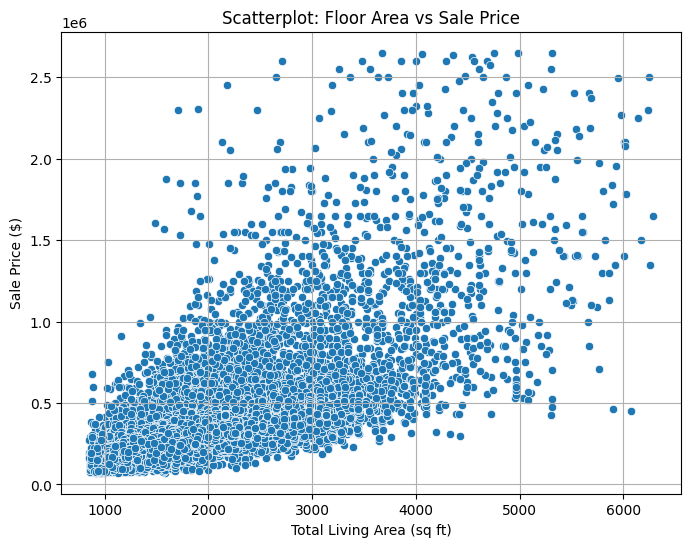

In [4]:
# Scatterplot: TOT_LVG_AREA vs SALE_PRC
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['TOT_LVG_AREA'], y=data['SALE_PRC'])
plt.title('Scatterplot: Floor Area vs Sale Price')
plt.xlabel('Total Living Area (sq ft)')
plt.ylabel('Sale Price ($)')
plt.grid(True)
plt.show()


Occurrences in structure_quality:
   structure_quality  count
3                  1    172
1                  2   4053
4                  3     16
0                  4   7546
2                  5   1989


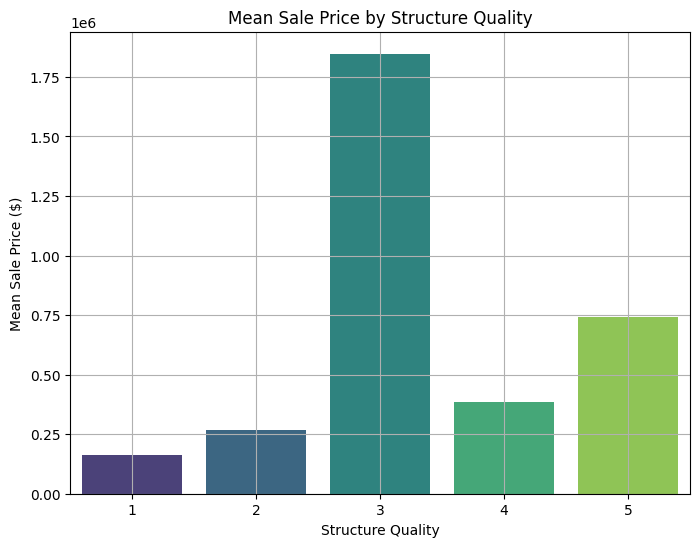

In [5]:
# Bar chart: Mean SALE_PRC by structure_quality (also count occurences)
structure_quality_counts = data['structure_quality'].value_counts().reset_index()
structure_quality_counts.columns = ['structure_quality', 'count']
structure_quality_counts = structure_quality_counts.sort_values(by='structure_quality')

print("\nOccurrences in structure_quality:")
print(structure_quality_counts)

mean_prices_by_quality = data.groupby('structure_quality')['SALE_PRC'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(
    x='structure_quality',
    y='SALE_PRC',
    data=mean_prices_by_quality,
    palette='viridis'
)
plt.title('Mean Sale Price by Structure Quality')
plt.xlabel('Structure Quality')
plt.ylabel('Mean Sale Price ($)')
plt.grid(True)
plt.show()

# XGBOOST - regression

## Defining parameter grid

Here we define the same parameter grid for all different type of optimization methods. Moreover, except for gridsearch we fix the number of runs for the other models by setting the evaluation_number parameter. (We are using decision tree regressors in all cases. No need for standardization since we are after cutpoints.)

The following hyperparameters control the behavior of the XGBoost model. Adjusting these can significantly impact model performance, particularly regarding overfitting and underfitting:

```python
param_grid = {
    'n_estimators': [100, 200, 300, 400],       # Number of trees in the ensemble
    'max_depth': [3, 5, 7, 9],                  # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Learning rate for gradient descent
    'subsample': [0.6, 0.7, 0.8, 0.9],          # Fraction of training data used for each tree
    'colsample_bytree': [0.5, 0.7, 0.9],        # Fraction of features used for each tree
    'reg_alpha': [0.01, 0.1, 1.0],              # L1 regularization (prevents overfitting large coefficients)
    'reg_lambda': [1.0, 5.0, 10.0],             # L2 regularization (penalizes high feature weights)
    'min_child_weight': [1, 2, 5, 10]           # Indirectly controls for minimum leaves
}
```

### 1. **n_estimators**
The number of boosting rounds or trees in the ensemble. Increasing the number of estimators can improve model accuracy by reducing bias, but it also increases the risk of overfitting if the model becomes too complex (the model becomes too specific to the training data and performs poorly on new data).

### 2. **max_depth**
The maximum depth of each decision tree in the ensemble. Deeper trees can capture more complex patterns, but they can also increase the risk of overfitting.

### 3. **learning_rate**
The step size shrinkage used to prevent overfitting. It scales the contribution of each tree in the model. A smaller `learning_rate` means that the model will learn more slowly but can potentially achieve better performance. However, it usually requires more trees (`n_estimators`).A high learning rate can lead to rapid overfitting because the model may converge too quickly to a suboptimal solution. A low learning rate can prevent the model from converging, resulting in underfitting if the number of estimators is not increased accordingly.

### 4. **subsample**
The fraction of the training data that is randomly sampled for each tree. Lowering `subsample` can help prevent overfitting by introducing more randomness, which makes the model more robust.

### 5. **colsample_bytree**
The fraction of features (columns) used to train each tree. Similar to `subsample`, reducing the number of features used in each tree can help prevent overfitting by adding randomness to the feature selection. If all features are used (`colsample_bytree = 1`), there’s a higher risk of overfitting, but very low values (e.g., `colsample_bytree < 0.5`) may lead to underfitting as the model won’t have enough information to capture the relationships between features.

### 6. **reg_alpha (L1 Regularization)**
L1 regularization term on weights (i.e., adding penalties to the absolute values of the weights). L1 regularization encourages sparsity in the model, effectively shrinking some feature weights to zero, which helps prevent overfitting. Lower `reg_alpha` values may lead to overfitting, as the model is less penalized for including unnecessary features.

### 7. **reg_lambda (L2 Regularization)**
L2 regularization term on weights (i.e., adding penalties to the squared values of the weights). L2 regularization helps smooth the model and can prevent overfitting by reducing the magnitude of feature weights. Low values of `reg_lambda` may result in overfitting as the model can assign high weights to certain features. High `reg_lambda` values work *vice versa*.

### 8. **min_child_weight**
Indirectly controls for the minimum amount of leaves in  partition. Lower the number, the more conservative the estimation will be.
---

## XGBoost (Extreme Gradient Boosting)

**XGBoost** is an advanced implementation of the gradient boosting algorithm. It builds an ensemble of decision trees sequentially, where each tree corrects the errors of the previous ones. XGBoost is known for its speed and performance, often outperforming other machine learning algorithms in structured/tabular data tasks.
- **Gradient Boosting**: Builds trees sequentially, minimizing the loss function using gradient descent, making it highly accurate for both regression and classification tasks.
- **Regularization**: Adds L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting, improving generalizability.
- **Parallelization**: Takes advantage of parallel and distributed computing (RAM and GPU both utilized).

---

## Optuna

**Optuna** is an automatic hyperparameter optimization framework. It efficiently finds the best hyperparameters for machine learning models using an optimization technique known as the **Tree-structured Parzen Estimator (TPE)**. Optuna supports both search space exploration and pruning techniques to accelerate convergence to the best set of hyperparameters.
- **Efficient Search**: Optuna uses intelligent exploration strategies (like TPE) to focus more on promising areas of the hyperparameter space.
- **Pruning**: Optuna prunes unpromising trials early, improving efficiency by focusing on trials with high potential.
- **Automatic Logging**: Automatically logs and visualizes the optimization process, simplifying the monitoring of the tuning process.

---

Baseline R² Score: 0.7952



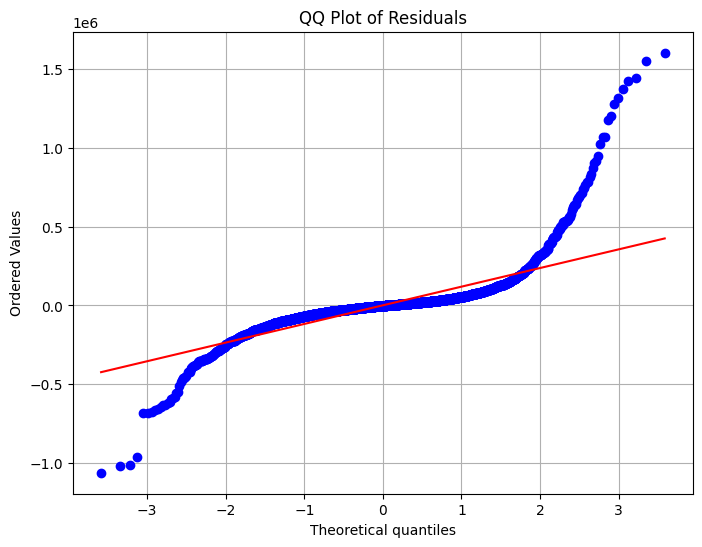

In [6]:
# One-hot encode structure_quality since it is a dummy var
data = pd.get_dummies(data, columns=['structure_quality'], prefix='quality', drop_first=True)

# Split features and target (plus drop the ID)
X = data.drop(columns=['SALE_PRC', 'PARCELNO'])
y = data['SALE_PRC']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBoost
xgboost_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    n_estimators=100,              # Number of trees
    max_depth=6,                   # Tree depth
    learning_rate=0.1,             # Step size shrinkage
    random_state=42                # Reproducibility
)

# Train and predict
xgboost_regressor.fit(X_train, y_train)
y_pred = xgboost_regressor.predict(X_test)

# Calculate model evaluation criterion
r2 = r2_score(y_test, y_pred)
print(f"Baseline R² Score: {r2:.4f}")
print()

# Create a QQ plot for residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.show()

# XGBOOST regression with Hyperparameter Tuning

In [24]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8]),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
    }

    # Train XGBoost model
    model = xgb.XGBRegressor(**param)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_test, y_test)],  # Validation set
        verbose=False  # Suppress verbose output
    )
    
    # Evaluate the model
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)  # Calculate R²
    return r2

# Run the Optuna study to maximize r squared and find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("\nBest Hyperparameters:")
print(study.best_params)

[I 2025-01-23 12:23:21,518] A new study created in memory with name: no-name-045e102f-155d-402f-87cd-0a5dbc870506
[I 2025-01-23 12:23:22,871] Trial 0 finished with value: 0.7918652389830098 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8, 'reg_alpha': 0.029956806808602493, 'reg_lambda': 5.863191070491434}. Best is trial 0 with value: 0.7918652389830098.
[I 2025-01-23 12:23:24,723] Trial 1 finished with value: 0.8001931056411408 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.6, 'reg_alpha': 0.17104718939151498, 'reg_lambda': 5.248964005491153}. Best is trial 1 with value: 0.8001931056411408.
[I 2025-01-23 12:23:26,513] Trial 2 finished with value: 0.7979046244063938 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_alpha': 0.03743798305549197, 'reg_lambda': 6.293209496302073}. Best is trial 1 with value: 0.8001931056411408.
[I 2025-01-23 12:23:27,408

In [25]:
# Train final model with optimized parameters
optimized_params = study.best_params
optimized_params['objective'] = 'reg:squarederror'
optimized_params['eval_metric'] = 'rmse'

final_model = xgb.XGBRegressor(**optimized_params)
final_model.fit(X_train, y_train)

# Evaluate final model
final_preds = final_model.predict(X_test)
final_r2 = r2_score(y_test, final_preds)  # Calculate final R²
print(f"\nFinal Model R²: {final_r2:.4f}")


Final Model R²: 0.7995


# Plot Feature Importances and Optimization Process

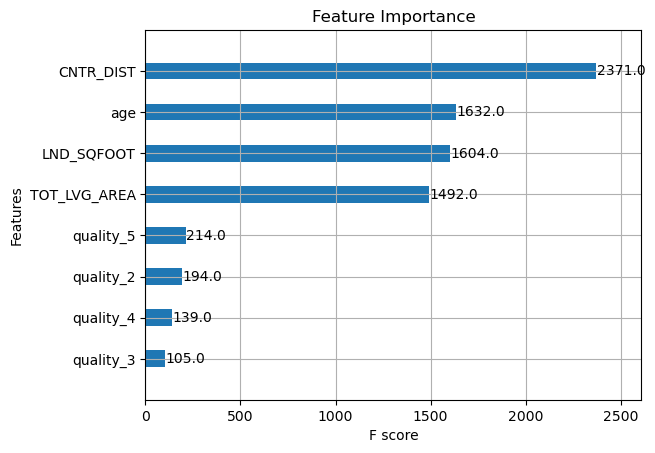

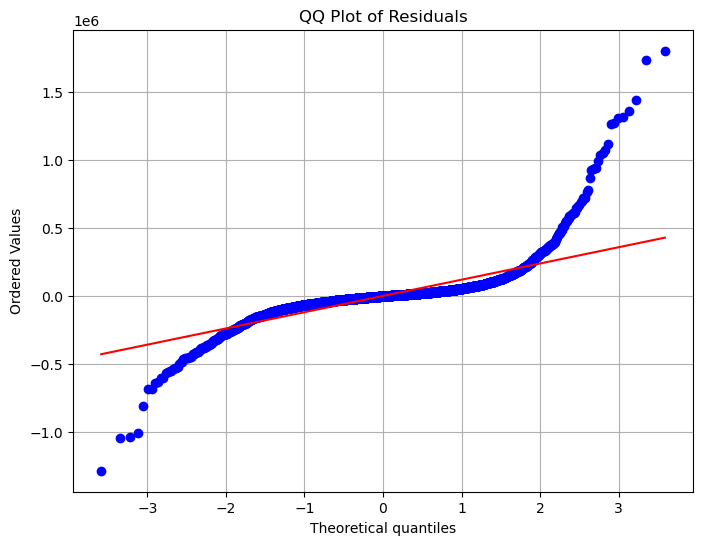

In [26]:
# 'weight': Frequency of splits (F Score).
# 'gain': Average improvement in loss (recommended for regression).
# 'cover': Proportion of data affected by the feature.
xgb.plot_importance(final_model, importance_type='weight', max_num_features=10, height=0.4) # Options: 'weight', 'gain', 'cover'
plt.title('Feature Importance')
plt.show()

# Create a QQ plot for residuals (difference between actuals and predictions)
residuals = y_test - y_pred  # Calculate residuals

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.show()

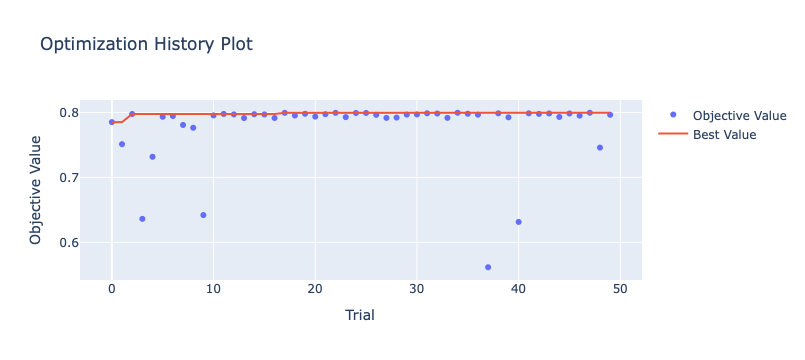

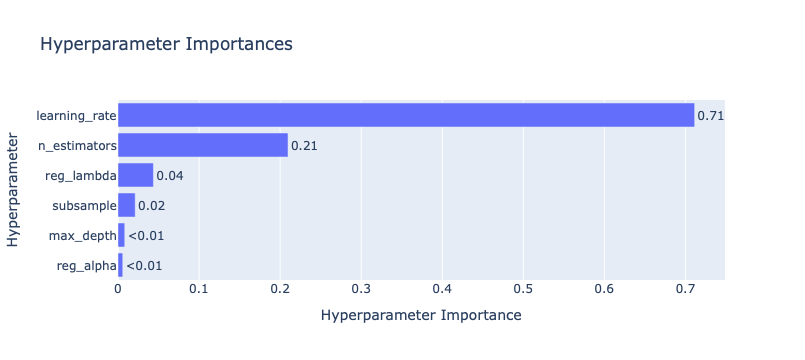

In [34]:
# Generate and render the optimization history plot
opt_hist = optuna.visualization.plot_optimization_history(study)
pio.show(opt_hist)

# Generate and render the parameter importances plot
param_imp = optuna.visualization.plot_param_importances(study)
pio.show(param_imp)

# Potential Solutions to Improve the Model

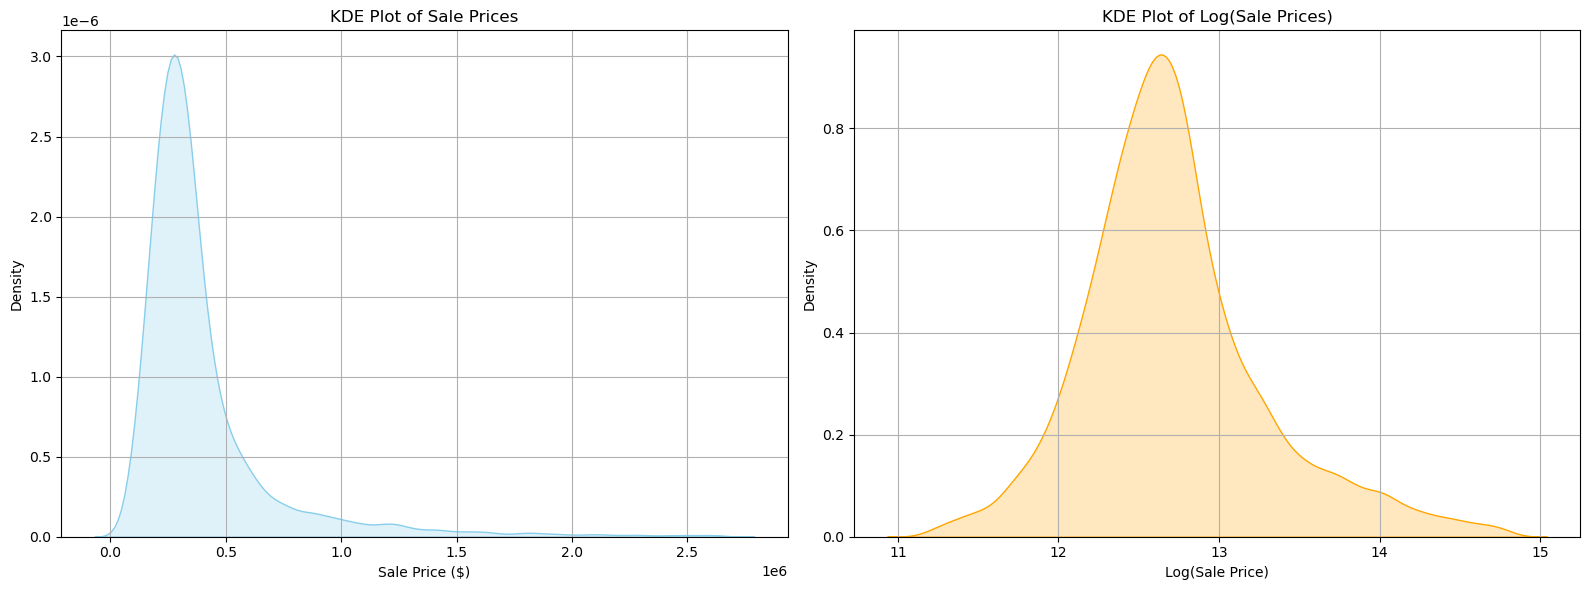

In [28]:
# Add a log-transformed column for prices
data['log_SALE_PRC'] = np.log1p(data['SALE_PRC'])

# Create a 1x2 subplot grid for KDE plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KDE plot for raw prices
sns.kdeplot(data['SALE_PRC'], fill=True, color='skyblue', ax=axes[0])
axes[0].set_title('KDE Plot of Sale Prices')
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# KDE plot for log-transformed prices
sns.kdeplot(data['log_SALE_PRC'], fill=True, color='orange', ax=axes[1])
axes[1].set_title('KDE Plot of Log(Sale Prices)')
axes[1].set_xlabel('Log(Sale Price)')
axes[1].set_ylabel('Density')
axes[1].grid(True)

plt.tight_layout()
plt.show()